<a href="https://colab.research.google.com/github/Jdean4747/Data5600HW/blob/main/BaggingAndBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import time

In [6]:
df = pd.read_csv('/content/bikeshare.csv')

In [7]:
df.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed,dteday,cnt
0,1,0,1,0,0,6,1,1,-1.334609,0.947345,-1.553844,2011-01-01,16
1,1,0,1,1,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,40
2,1,0,1,2,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,32
3,1,0,1,3,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,13
4,1,0,1,4,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,1


In [8]:
X = df.drop(columns=["cnt", "dteday"])
y = df["cnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

In [9]:
rf_reg = RandomForestRegressor(random_state=1000)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=1000)

In [10]:
y_hat = rf_reg.predict(X_test)
df_predictions = pd.DataFrame({"y_test": y_test.values,"y_hat": y_hat})
df_predictions.head()

,y_test,y_hat
0,26,21.38
1,47,64.21
2,11,4.91
3,205,199.84
4,65,80.55


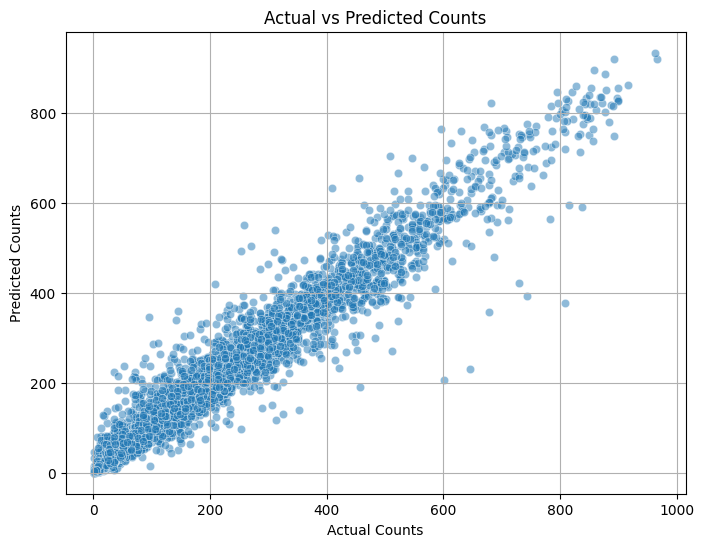

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="y_test", y="y_hat", data=df_predictions, alpha=0.5)
plt.xlabel("Actual Counts")
plt.ylabel("Predicted Counts")
plt.title("Actual vs Predicted Counts")
plt.grid(True)
plt.show()

Most of the points are in the middle which means that the predicted counts are predicted correctly often.  

In [12]:
r2 = r2_score(y_test, y_hat)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print("R2:",r2)
print("RMSE:",rmse)

R2: 0.9487843353334885
RMSE: 41.82488908065619


In [13]:
my_param_grid = {'n_estimators':[100,200], 'max_features':['log2', 'sqrt'], 'max_depth':[10,None]}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=1000, oob_score=True),param_grid=my_param_grid,cv=5,scoring='r2',n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_hat_tuned = best_model.predict(X_test)
r2_tuned = r2_score(y_test, y_hat_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_hat_tuned))
print("Tuned R2:",r2_tuned)
print("Tuned RMSE:",rmse_tuned)
print("Best Params:", grid_search.best_params_)

Tuned R2: 0.904642157198726
Tuned RMSE: 57.070489843282715
Best Params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}


I was not able to improve as my R2 went down and my RMSE went up

In [14]:
cv_r2 = grid_search.best_score_
print("Cross-validated R2:",cv_r2)
oob_r2 = best_model.oob_score_
print("OOB R2:",oob_r2)


Cross-validated R2: 0.8932265894304103
OOB R2: 0.9022236312084309


These numbers show that this model takes good care of the variance and generalizes well

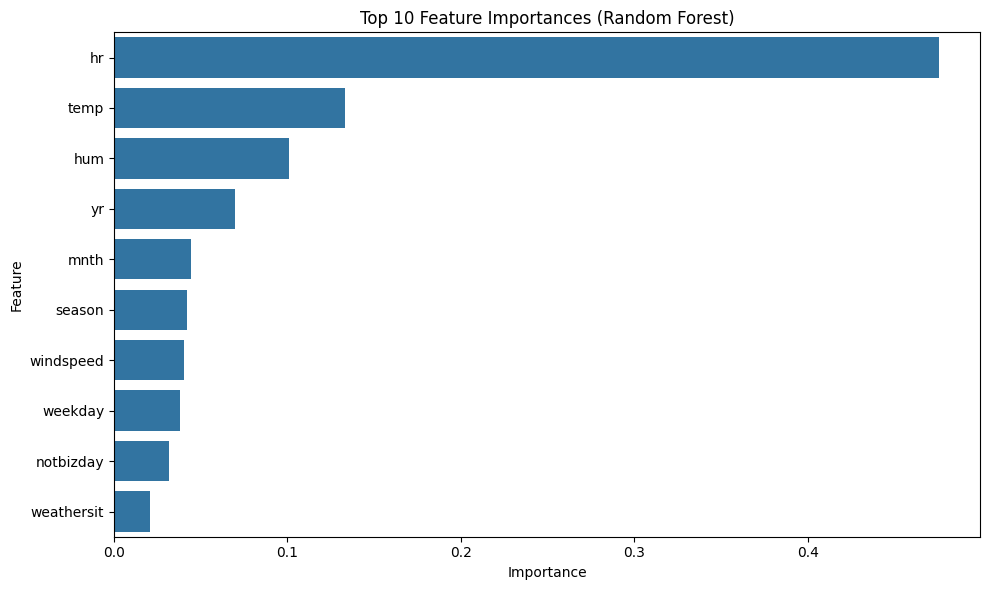

Top 5 Features (Random Forest):
  Feature  Importance
3      hr    0.475580
8    temp    0.133231
9     hum    0.100916
1      yr    0.069944
2    mnth    0.044356


In [15]:
rf_importances = best_model.feature_importances_
rf_feat_df = pd.DataFrame({'Feature': X.columns,'Importance': rf_importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_feat_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
print("Top 5 Features (Random Forest):")
print(rf_feat_df.head(5))

In [16]:
X_train_lr = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_lr).fit()

pvals = ols_model.pvalues.sort_values()
print("Top 5 Most Significant Features (Linear Regression):")
print(pvals.head(6))

Top 5 Most Significant Features (Linear Regression):
temp          0.000000e+00
hr           7.126101e-299
yr           1.563267e-205
hum          1.359113e-123
season        6.683513e-20
windspeed     5.090983e-04
dtype: float64


Windspeed is shown as more important in Linear Regression than Random Forest. The random forest can see things that the Linear Regression cannot such as the windspeed being highly related to the seasons changing

In [17]:
df['overload'] = (df['cnt'] > 500).astype(int)
print(df['overload'].value_counts(normalize=True))


overload
0    0.926405
1    0.073595
Name: proportion, dtype: float64


This is very imbalanced and means that accuracy will not be as correct as it says it is

In [18]:
X = df.drop(columns=['cnt', 'overload','dteday'])
y = df['overload']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

In [19]:
rf_clf = RandomForestClassifier(random_state=1000)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=1000)

In [20]:
y_hat_probs = rf_clf.predict_proba(X_test)[:, 1]
y_hat = rf_clf.predict(X_test)

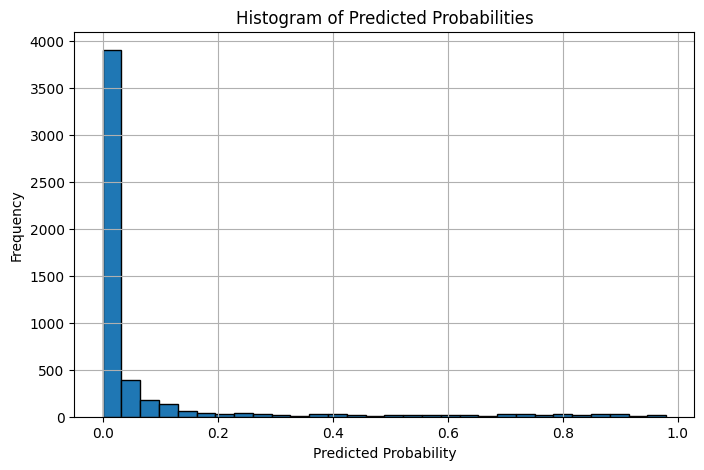

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(y_hat_probs, bins=30, edgecolor='k')
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


This model shows that it predicts non-overload cases most of the time. This model seems to struggle with the predictions with overload cases as there seems to be very little.

In [22]:
print("Classification Report:")
print(classification_report(y_test, y_hat))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_hat))
print("F1 Score on Test Set:", f1_score(y_test, y_hat))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4830
           1       0.93      0.73      0.82       384

    accuracy                           0.98      5214
   macro avg       0.95      0.86      0.90      5214
weighted avg       0.98      0.98      0.97      5214

Confusion Matrix:
[[4809   21]
 [ 105  279]]
F1 Score on Test Set: 0.8157894736842105


This a great classification report with everything pretty high. The Overload scores were worse meaning that the model is not as good at predicting those. This model overall predicts very well, but we might not be able to trust accuracy because of the imbalanced amount of overloads vs non-overloads.

In [23]:
parameter_grid = {'n_estimators': [100, 200],'criterion': ['gini', 'entropy'],'max_features': ['log2', 'sqrt'],'max_depth': [10, None]}
grid_search = GridSearchCV(estimator=rf_clf,param_grid=parameter_grid,scoring='f1',cv=5,n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_hat_best = best_rf.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Classification Report Tuned RF:")
print(classification_report(y_test, y_hat_best))

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Classification Report Tuned RF:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4830
           1       0.92      0.71      0.80       384

    accuracy                           0.97      5214
   macro avg       0.95      0.85      0.90      5214
weighted avg       0.97      0.97      0.97      5214



This was a bushy tree because the max_depth is None so it used all of the data. I was not able to improve the model's perfomance using this tuned version.

In [27]:
rf_oob = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1000)
rf_oob.fit(X_train, y_train)
print("OOB Accuracy:", rf_oob.oob_score_)
cv_scores = cross_val_score(rf_oob, X_train, y_train, cv=5, scoring='accuracy')
print("CV Accuracy (5-fold):", cv_scores.mean())


OOB Accuracy: 0.9727085902178381
CV Accuracy (5-fold): 0.9718043567612001


In [28]:
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=1000)
rf_balanced.fit(X_train, y_train)
y_hat_balanced = rf_balanced.predict(X_test)
print("Balanced Classification Report:")
print(classification_report(y_test, y_hat_balanced))
balanced_precision = precision_score(y_test, y_hat_balanced)
balanced_recall = recall_score(y_test, y_hat_balanced)
balanced_f1 = f1_score(y_test, y_hat_balanced)
print("Balanced Precision:", balanced_precision)
print("Balanced Recall:", balanced_recall)
print("Balanced F1:", balanced_f1)

Balanced Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4830
           1       0.92      0.70      0.79       384

    accuracy                           0.97      5214
   macro avg       0.95      0.85      0.89      5214
weighted avg       0.97      0.97      0.97      5214

Balanced Precision: 0.9175257731958762
Balanced Recall: 0.6953125
Balanced F1: 0.7911111111111111


The recall decreased a little bit which does make sense because balancing doesn't neccesarily change these numbers positively

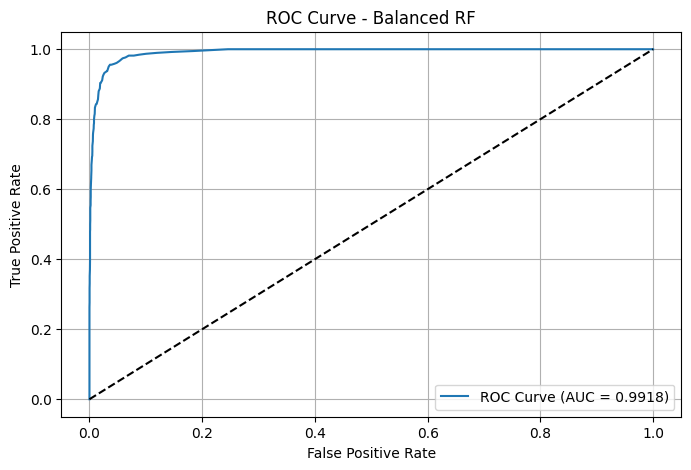

AUC Score: 0.991767490510697


In [31]:
y_probs_balanced = rf_balanced.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_balanced)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Balanced RF')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_score)


We can trust this because the AUC score shows the differences in classes even with the imbalances. You do want to look at precision, recall, and f1 to make sure however.  

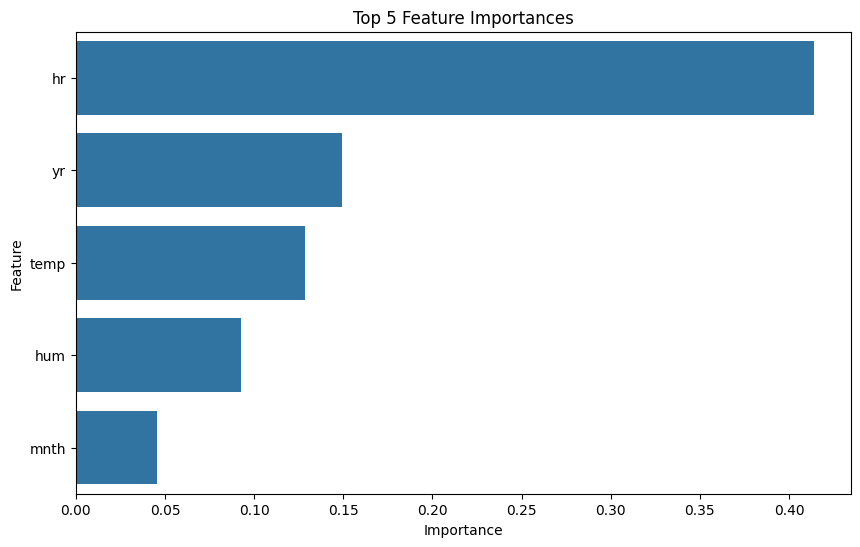

Top 5 Features:
  Feature  Importance
3      hr    0.413905
1      yr    0.149496
8    temp    0.128262
9     hum    0.092844
2    mnth    0.045273


In [35]:
importances = rf_balanced.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df_sorted = feat_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df_sorted.head(5), x='Importance', y='Feature')
plt.title("Top 5 Feature Importances")
plt.show()
print("Top 5 Features:")
print(feat_df_sorted.head(5))


Yes this makes sense because it varies with time of day when people are going to bike and all of these things also are varient of when you are biking.

In [41]:
models = {"Random Forest": RandomForestClassifier(random_state=1000),"AdaBoost": AdaBoostClassifier(random_state=1000),"Gradient Boosting": GradientBoostingClassifier(random_state=1000),"XGBoost": XGBClassifier(eval_metric='logloss', random_state=1000)}
results = []
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    end = time.time()
    results.append({"Model": name,"F1 Score": f1,"Time (s)": round(end - start, 4)})
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(results_df)

               Model  F1 Score  Time (s)
3            XGBoost  0.857531    0.2029
0      Random Forest  0.815789    1.4430
2  Gradient Boosting  0.781065    1.6404
1           AdaBoost  0.428298    0.6516


Execution Speed:
XGBoost,
AdaBoost,
Random Forest,
Gradient Boosting

Performance:
XGBoost,
Random Forest,
Gradient Boosting,
AdaBoost

Overall Winner:
XGBoost